In [92]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from PIL import Image

from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, load_model
import tf_explain as tfe
import tensorflow as tf

print("All packages loaded.")


All packages loaded.


In [11]:
#Show dataset labels sorted.

from os import listdir
#from natsort import natsorted
#path = 'C:/Users/Nicko/Desktop/HCI/data'
path = 'C:/Users/Nikos/Desktop/HCI/computer_vision/data'
paths = listdir('C:/Users/Nikos/Desktop/HCI/computer_vision/data')
#paths = listdir('C:/Users/Nicko/Desktop/HCI/data')
paths = paths[:20]
print(paths)
"""
labels_dict = {path : x for x, path in enumerate(natsorted(paths))}
print(labels_dict)
labels = list(labels_dict.keys())
print(labels)
print(len(labels))
"""

['colored', 'white']


'\nlabels_dict = {path : x for x, path in enumerate(natsorted(paths))}\nprint(labels_dict)\nlabels = list(labels_dict.keys())\nprint(labels)\nprint(len(labels))\n'

In [15]:
# Preprocessing
# Resize images to 224 x 224.

def load_and_resize(paths):
    images = []
    colors = []
    
    for i, color in enumerate(paths):
        for img_name in listdir(path+"/"+color):
            img = cv2.imread(path+"/"+color+"/"+img_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            images_array = Image.fromarray(img, 'RGB')
            #print(isinstance(images, list))
            #resize image for the CNN.
            resized = images_array.resize((224, 224))
            
            images.append(np.array(resized))
            
            colors.append(i)
    
    return images, colors
    
images, labels = load_and_resize(paths)

print("The dataset contains ", len(images), " images")
print("The dataset contains ", len(labels), " labels")

The dataset contains  5929  images
The dataset contains  5929  labels


0.0
0.0


In [18]:
# Turning lists to np arrays.
images = np.array(images)
labels = np.array(labels)

print(images.shape, labels.shape)

# First shuffle the data in an equal range
seed = 42
data = np.arange(images.shape[0])

np.random.seed(seed)
np.random.shuffle(data)
print("Data after shuffling = ", data)

images = images[data]
labels = labels[data]

# Normalize dataset. We divide by 255 in order to take values between [0,1]

images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255
images.shape
labels.shape


(5929, 224, 224, 3) (5929,)
Data after shuffling =  [4733 1268 4082 ... 5226 5390  860]


(5929,)

In [20]:
# Separate white and colored clothes
white_indices = np.where(labels == 1)[0]
colored_indices = np.where(labels == 0)[0]

# Calculate the proportion of white and colored clothes
white_proportion = len(white_indices) / len(labels)
colored_proportion = len(colored_indices) / len(labels)
print(white_proportion)
print(colored_proportion)

0.15314555574295835
0.8468544442570417


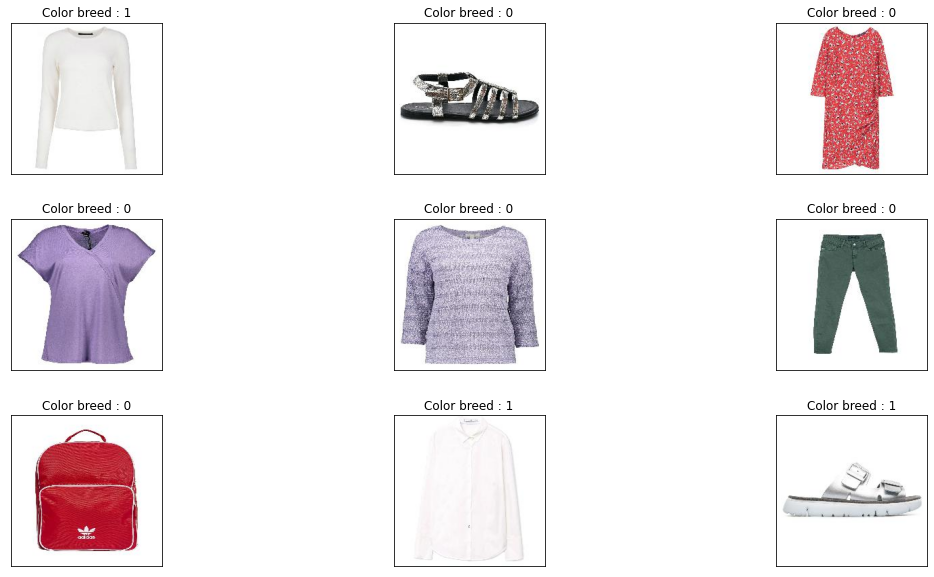

In [21]:
# Let's display some random imgs from our dataset
# to see that everything is good.

def display_rand_imgs(images, labels):
    
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
        plt.title('Color breed : {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()

display_rand_imgs(images, labels)  

# keep in mind that ['black', 'blue', 'brown', 'green', 'grey', 
                #'orange', 'pink', 'purple', 'red', 'silver', 'white', 'yellow']

In [34]:
from keras.utils.np_utils import to_categorical
# Split dataset in train, test
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = seed)


print("x_train shape = ",X_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",X_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (4743, 224, 224, 3)
y_train shape =  (4743,)

x_test shape =  (1186, 224, 224, 3)
y_test shape =  (1186,)


In [37]:
# Count the number of white and colored pictures in the train set
num_white_pictures = np.sum(y_train == 1)
num_colored_pictures = np.sum(y_train== 0)

print("Number of white pictures in the train set:", num_white_pictures)
print("Number of colored pictures in the train set:", num_colored_pictures)

Number of white pictures in the train set: 720
Number of colored pictures in the train set: 4023


In [38]:
np.unique(y_train)

array([0, 1])

In [39]:
# Here we will construct our CNN Model.
# We will add Max Pooling layers and Drop Out Layers with Batch Normalization.

model = Sequential()

# Starting with the input conv layer

model.add(Conv2D(filters = 96, kernel_size = (11,11), strides = (4,4), padding = "same", activation = "relu", input_shape = (224, 224, 3)))

# Max Pooling layer
model.add(MaxPooling2D(pool_size = (3,3), strides = (2,2)))
model.add(BatchNormalization())

# 2nd conv layer

model.add(Conv2D(filters = 256, kernel_size = (5,5), strides = (1,1), padding = "same", activation  = "relu"))

# Max Pooling layer
model.add(MaxPooling2D(pool_size = (3,3), strides = (2,2)))
model.add(BatchNormalization())

# Continue with 3 stacked conv layers

model.add(Conv2D(filters = 384, kernel_size = (3,3), strides = (1,1), padding = "valid", activation  = "relu"))

model.add(Conv2D(filters = 384, kernel_size = (3,3), strides = (1,1), padding = "valid", activation  = "relu"))

model.add(Conv2D(filters = 256, kernel_size = (5,5), strides = (1,1), padding = "valid", activation  = "relu"))

# Max Pooling layer
model.add(MaxPooling2D(pool_size = (3,3), strides = (2,2)))
model.add(BatchNormalization())

model.add(Flatten())

# Adding 3 dense layers and Dropout Layers
model.add(Dense(4096, input_shape = (227, 227, 3), activation = "relu"))

model.add(Dropout(0.4))
model.add(BatchNormalization())

model.add(Dense(4096, activation = "relu"))

model.add(Dropout(0.4))
model.add(BatchNormalization())

model.add(Dense(1000, activation = "relu"))

model.add(Dropout(0.4))
model.add(BatchNormalization())

# We use softmax because our clothes can classify to just one color category. 
model.add(Dense(1, activation = "sigmoid"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 56, 56, 96)        34944     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 27, 27, 96)       384       
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                             
                                                      

In [40]:
# Compile and train
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.fit(X_train, y_train, epochs = 100)

Epoch 1/100
149/149 [==============================] - 171s 1s/step - loss: 0.3960 - accuracy: 0.8661
Epoch 2/100
149/149 [==============================] - 175s 1s/step - loss: 0.2344 - accuracy: 0.9064
Epoch 3/100
149/149 [==============================] - 175s 1s/step - loss: 0.2208 - accuracy: 0.9129
Epoch 4/100
149/149 [==============================] - 178s 1s/step - loss: 0.2118 - accuracy: 0.9119
Epoch 5/100
149/149 [==============================] - 177s 1s/step - loss: 0.2013 - accuracy: 0.9220
Epoch 6/100
149/149 [==============================] - 177s 1s/step - loss: 0.1954 - accuracy: 0.9178
Epoch 7/100
149/149 [==============================] - 179s 1s/step - loss: 0.1798 - accuracy: 0.9228
Epoch 8/100
149/149 [==============================] - 177s 1s/step - loss: 0.1920 - accuracy: 0.9209
Epoch 9/100
149/149 [==============================] - 177s 1s/step - loss: 0.1707 - accuracy: 0.9283
Epoch 10/100
149/149 [==============================] - 176s 1s/step - loss: 0.174

149/149 [==============================] - 178s 1s/step - loss: 0.0534 - accuracy: 0.9831
Epoch 81/100
149/149 [==============================] - 177s 1s/step - loss: 0.1486 - accuracy: 0.9450
Epoch 82/100
149/149 [==============================] - 178s 1s/step - loss: 0.1116 - accuracy: 0.9568
Epoch 83/100
149/149 [==============================] - 177s 1s/step - loss: 0.0843 - accuracy: 0.9654
Epoch 84/100
149/149 [==============================] - 178s 1s/step - loss: 0.0737 - accuracy: 0.9717
Epoch 85/100
149/149 [==============================] - 178s 1s/step - loss: 0.0666 - accuracy: 0.9753
Epoch 86/100
149/149 [==============================] - 178s 1s/step - loss: 0.0546 - accuracy: 0.9793
Epoch 87/100
149/149 [==============================] - 177s 1s/step - loss: 0.0603 - accuracy: 0.9768
Epoch 88/100
149/149 [==============================] - 177s 1s/step - loss: 0.0458 - accuracy: 0.9840
Epoch 89/100
149/149 [==============================] - 178s 1s/step - loss: 0.0405 - 

In [42]:
loss, accuracy = model.evaluate(X_test, y_test)

print(loss,accuracy)

38/38 [==============================] - 9s 228ms/step - loss: 0.5303 - accuracy: 0.8558
0.5302656888961792 0.8558178544044495


In [44]:
pred = model.predict(X_test)

pred.shape

38/38 [==============================] - 9s 226ms/step


(1186, 1)

In [82]:
model.save('C:/Users/Nikos/Desktop/HCI/computer_vision/model.h5')

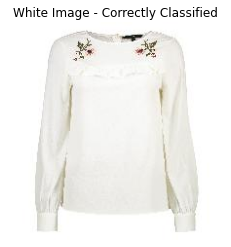

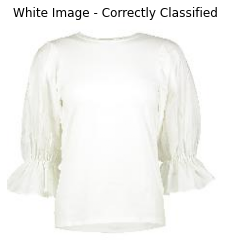

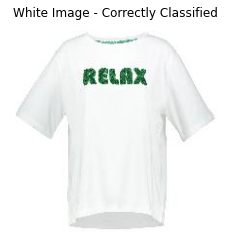

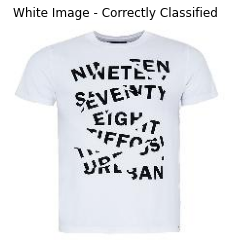

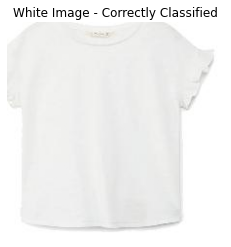

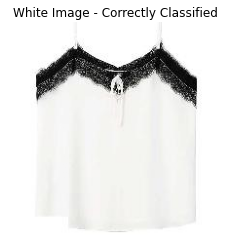

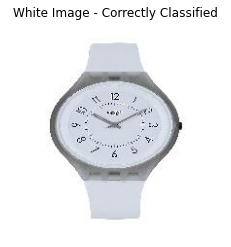

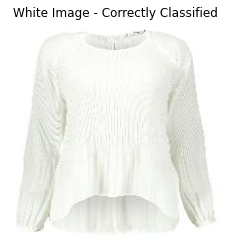

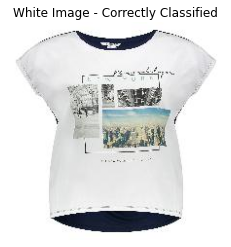

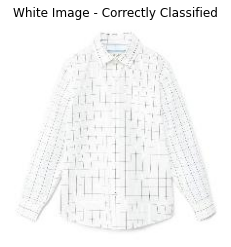

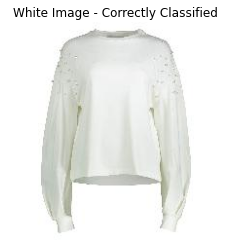

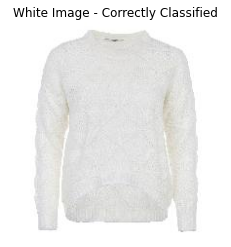

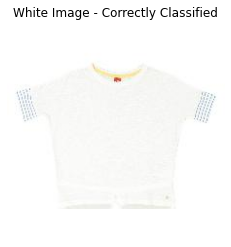

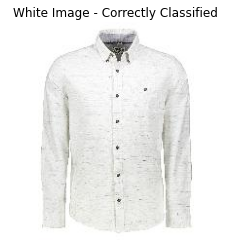

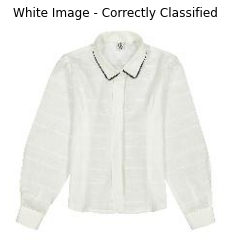

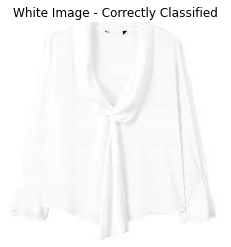

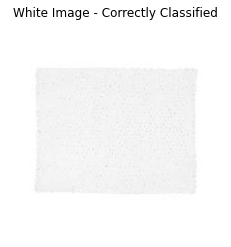

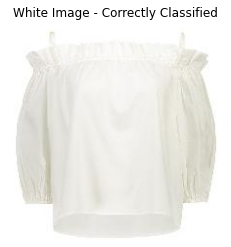

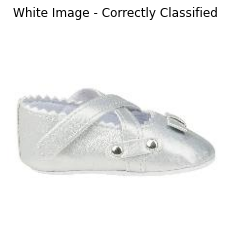

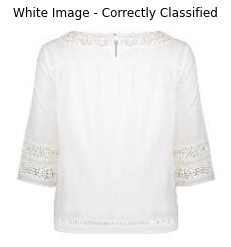

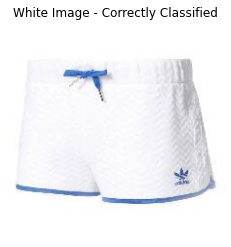

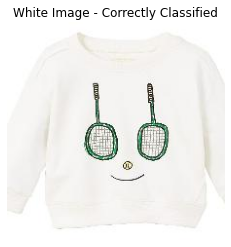

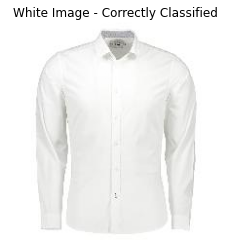

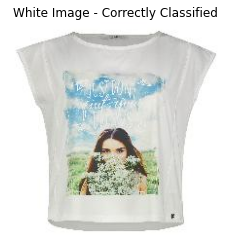

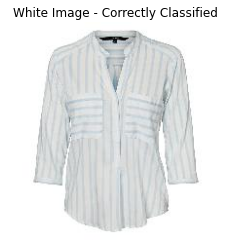

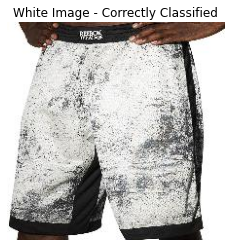

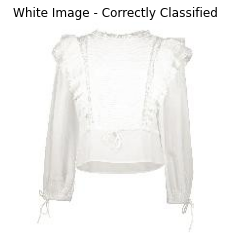

In [69]:
predicted_labels = np.round(pred).astype(int)

# Iterate over the test set images and labels
for i in range(len(X_test)):
    true_label = y_test[i]
    predicted_label = predicted_labels[i]
    image = X_test[i]

    # Check if the image is white and classified correctly
    if true_label == 1 and true_label == predicted_label:
        # Plot the image
        plt.imshow(image)
        plt.title("White Image - Correctly Classified")
        plt.axis("off")
        plt.show()

In [29]:
# Compile and train
# model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
# model.fit(X_train, y_train, epochs = 100)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
156/156 [==============================] - 181s 1s/step - loss: 2.0533 - accuracy: 0.3653
Epoch 2/100
156/156 [==============================] - 175s 1s/step - loss: 1.5901 - accuracy: 0.5033
Epoch 3/100
156/156 [==============================] - 176s 1s/step - loss: 1.3370 - accuracy: 0.5843
Epoch 4/

156/156 [==============================] - 190s 1s/step - loss: 0.3284 - accuracy: 0.8898
Epoch 72/100
156/156 [==============================] - 192s 1s/step - loss: 0.2502 - accuracy: 0.9142
Epoch 73/100
156/156 [==============================] - 190s 1s/step - loss: 0.2151 - accuracy: 0.9289
Epoch 74/100
156/156 [==============================] - 190s 1s/step - loss: 0.2576 - accuracy: 0.9112
Epoch 75/100
156/156 [==============================] - 193s 1s/step - loss: 0.2441 - accuracy: 0.9199
Epoch 76/100
156/156 [==============================] - 193s 1s/step - loss: 0.2216 - accuracy: 0.9283
Epoch 77/100
156/156 [==============================] - 193s 1s/step - loss: 0.2796 - accuracy: 0.9088
Epoch 78/100
156/156 [==============================] - 193s 1s/step - loss: 0.2081 - accuracy: 0.9279
Epoch 79/100
156/156 [==============================] - 193s 1s/step - loss: 0.2088 - accuracy: 0.9351
Epoch 80/100
156/156 [==============================] - 191s 1s/step - loss: 0.2344 - 

In [47]:
# model.save('C:/Users/Nikos/Desktop/HCI/computer_vision/')

INFO:tensorflow:Assets written to: C:/Users/Nikos/Desktop/HCI/computer_vision/assets


INFO:tensorflow:Assets written to: C:/Users/Nikos/Desktop/HCI/computer_vision/assets


In [73]:
# pred = model.predict(X_test)
# predicted_labels = np.argmax(pred, axis=1)
# true_labels = np.argmax(y_test, axis=1)
# accuracy = np.mean(predicted_labels == true_labels)
# print(accuracy)

39/39 [==============================] - 9s 230ms/step
0.483974358974359


In [81]:
# loss, accuracy = model.evaluate(X_test, y_test)
# print(loss, accuracy)
# pred = model.predict(X_test)
# predicted_labels = np.argmax(pred, axis=1)

In [52]:
pred.shape
print(r.dtype)
print(y_test.dtype)
print(pred.dtype)
y_test = y_test.astype(int)
pred = pred.astype(int)

int32
float32
float32


In [66]:
# print(y_test[0])
# print(predicted_labels)

[0 0 0 0 0 0 1 0 0 0 0 0]
[6 6 8 ... 7 9 6]


Correctly classified white clothes:


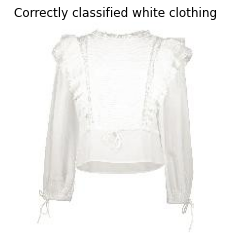

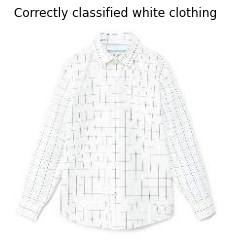

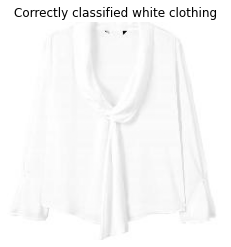

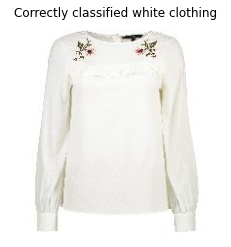

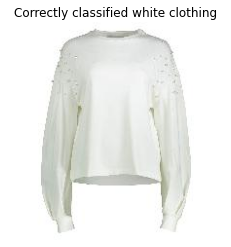

Misclassified colored images:


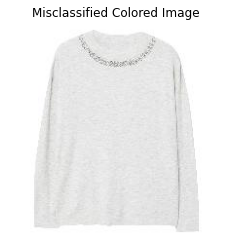

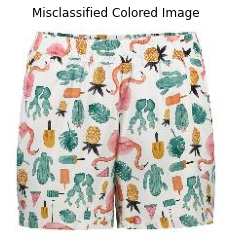

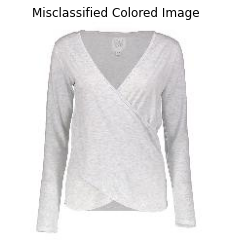

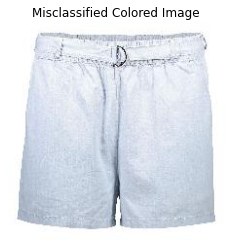

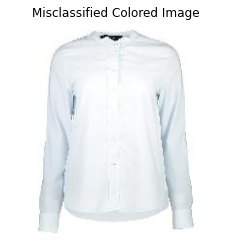

In [79]:
correctly_classified_white = []
correctly_classified_colored = []
misclassified_images = []
misclassified_colored_images = []

# Iterate over the test set images and labels
for i in range(len(X_test)):
    true_label = y_test[i]
    predicted_label = predicted_labels[i]
    image = X_test[i]

    # Check if the image is white and classified correctly
    if true_label == 1 and true_label == predicted_label:
        correctly_classified_white.append(image)
    # Check if the image is colored and classified correctly
    elif true_label == 0 and true_label == predicted_label:
        correctly_classified_colored.append(image)
    elif true_label == 0 and true_label != predicted_label:
        misclassified_colored_images.append(image)
    else:
        misclassified_images.append(image)

        
# Plot a random selection of misclassified images
print("Correctly classified white clothes:")
np.random.shuffle(correctly_classified_white)
for i in range(5):  # Change the number to the desired count of images to display
    plt.imshow(correctly_classified_white[i])
    plt.title("Correctly classified white clothing")
    plt.axis("off")
    plt.show()

# Plot a random selection of misclassified colored images
print("Misclassified colored images:")
np.random.shuffle(misclassified_colored_images)
for i in range(5):  # Change the number to the desired count of images to display
    plt.imshow(misclassified_colored_images[i])
    plt.title("Misclassified Colored Image")
    plt.axis("off")
    plt.show()

In [80]:
"""
correct_indices = np.where(predicted_labels == y_test)[0]
# Set the number of images you want to plot
num_images = 10

# Randomly select 'num_images' indices from the correct predictions
selected_indices = np.random.choice(correct_indices, size=num_images, replace=False)

# Plot the selected images
plt.figure(figsize=(12, 8))
for i, idx in enumerate(selected_indices):
    plt.subplot(5, 2, i + 1)
    plt.imshow(X_test[idx])
    plt.title(f"True: {y_test[idx]}, Predicted: {predicted_labels[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

print("Predicted wrongly.")

wrong_indices = np.where(predicted_labels != y_test)[0]
# Set the number of images you want to plot
num_images = 10

# Randomly select 'num_images' indices from the wrong predictions
selected_indices = np.random.choice(wrong_indices, size=num_images, replace=False)

# Plot the selected images
plt.figure(figsize=(12, 8))
for i, idx in enumerate(selected_indices):
    plt.subplot(5, 2, i + 1)
    plt.imshow(X_test[idx])
    plt.title(f"True: {y_test[idx]}, Predicted: {predicted_labels[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
"""

'\ncorrect_indices = np.where(predicted_labels == y_test)[0]\n# Set the number of images you want to plot\nnum_images = 10\n\n# Randomly select \'num_images\' indices from the correct predictions\nselected_indices = np.random.choice(correct_indices, size=num_images, replace=False)\n\n# Plot the selected images\nplt.figure(figsize=(12, 8))\nfor i, idx in enumerate(selected_indices):\n    plt.subplot(5, 2, i + 1)\n    plt.imshow(X_test[idx])\n    plt.title(f"True: {y_test[idx]}, Predicted: {predicted_labels[idx]}")\n    plt.axis(\'off\')\n\nplt.tight_layout()\nplt.show()\n\nprint("Predicted wrongly.")\n\nwrong_indices = np.where(predicted_labels != y_test)[0]\n# Set the number of images you want to plot\nnum_images = 10\n\n# Randomly select \'num_images\' indices from the wrong predictions\nselected_indices = np.random.choice(wrong_indices, size=num_images, replace=False)\n\n# Plot the selected images\nplt.figure(figsize=(12, 8))\nfor i, idx in enumerate(selected_indices):\n    plt.subpl

In [93]:
#Convert model in Js.
tfjs.converters.save_keras_model(model, 'tfjs_model')

NameError: name 'tfjs' is not defined